<a href="https://colab.research.google.com/github/shrabonbiswas/Thesis_final_output/blob/main/CNN_MDD_with_DAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import library

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread


In [ ]:
import os
import shutil

# Source: Google Drive file
src_file = "/content/drive/MyDrive/Thesis/dataset/thesis.zip"

# Destination: Colab local directory
dest_file = "/content/thesis.zip"

# ফাইল আছে কিনা চেক করা
if os.path.exists(src_file):
    shutil.copy(src_file, dest_file)
    print("✅ File copied successfully!")
else:
    print(f"❌ Source file পাওয়া যায়নি: {src_file}")

✅ File copied successfully!


In [ ]:
import zipfile
import os

zip_path = '/content/thesis.zip'
extract_path = '/content/extracted_thesis'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ File extracted to: {extract_path}")

✅ File extracted to: /content/extracted_thesis


In [ ]:
import os

dest_path = "/content/extracted_thesis/data"
dataset_path = dest_path

total_images = 0
class_counts = {}

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])
        class_counts[class_name] = num_images
        total_images += num_images

print(f"\n✅ Total number of images: {total_images}")
print(f"✅ Number of classes: {len(class_counts)}")
print("📊 Images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")



✅ Total number of images: 4188
✅ Number of classes: 4
📊 Images per class:
  Common_Rust: 1306 images
  Healthy: 1162 images
  Blight: 1146 images
  Gray_Leaf_Spot: 574 images


📌 Selected Image: Corn_Blight (387).JPG


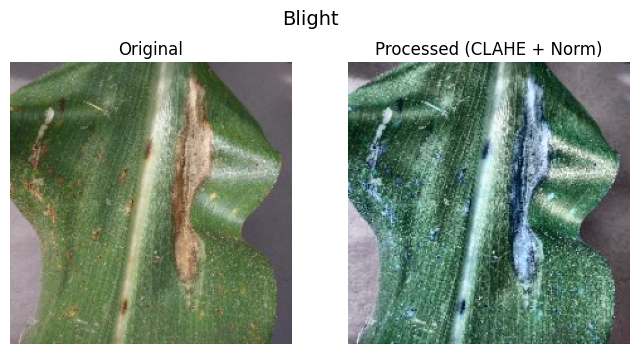

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random   # নতুন যোগ করা হয়েছে

# ✅ ইনপুট এবং আউটপুট ফোল্ডার
input_folder = dest_path
output_folder = 'blight_dataset_processed'

# ✅ টার্গেট সাইজ
target_size = (224, 224)

# ✅ CLAHE সেটআপ
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# ✅ Image preprocessing ফাংশন
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    img_resized = cv2.resize(img, target_size)

    # CLAHE প্রয়োগ
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Normalization
    img_normalized = img_clahe.astype('float32') / 255.0

    return img_resized, img_normalized

# ✅ Image Preview ফাংশন
def show_images(original, processed, title=''):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(processed)
    plt.title('Processed (CLAHE + Norm)')
    plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.show()

# ✅ 'blight' ক্লাস থেকে random একটি ছবি নেওয়া
all_classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
blight_classes = [c for c in all_classes if 'blight' in c.lower()]

if not blight_classes:
    print("❌ 'blight' নামের কোনো ক্লাস পাওয়া যায়নি!")
    print("ℹ️ Available classes:", all_classes)
else:
    sample_class = blight_classes[0]   # প্রথম blight ক্লাসটি নিলাম
    class_dir = os.path.join(input_folder, sample_class)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    if not images:
        print(f"❌ '{sample_class}' ক্লাসে কোনো ছবি পাওয়া যায়নি!")
    else:
        sample_img = random.choice(images)   # 🎲 random একটি ইমেজ বাছাই
        img_path = os.path.join(class_dir, sample_img)

        original_img, processed_img = preprocess_image(img_path)
        if original_img is None:
            print("❌ ছবিটি পড়া যায়নি:", img_path)
        else:
            print(f"📌 Selected Image: {sample_img}")
            show_images(original_img, processed_img, title=sample_class)


In [ ]:
# ✅ batch preprocessing + save
for class_name in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    save_class_path = os.path.join(output_folder, class_name)
    os.makedirs(save_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_class_path, img_name)

        original_img, processed_img = preprocess_image(img_path)
        if processed_img is not None:
            # [0,1] → [0,255] → uint8 → BGR
            processed_img_uint8 = (processed_img * 255).astype('uint8')
            cv2.imwrite(save_path, processed_img_uint8)

In [ ]:
classwise_hsv_ranges = {
    'Blight':         ([0, 0, 0], [180, 255, 255]),
    'Gray_Leaf_Spot': ([0, 0, 0], [180, 255, 255]),
    'Common_Rust':    ([0, 0, 0], [180, 255, 255]),
    'Healthy':        ([0, 0, 0], [180, 255, 255])
}

In [ ]:
def smart_leaf_crop(img_path, class_name, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None, None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # ✅ HSV range
    lower_val, upper_val = classwise_hsv_ranges.get(class_name, ([25,40,40], [95,255,255]))
    lower_green = np.array(lower_val)
    upper_green = np.array(upper_val)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    # ✅ কনট্যুর খুঁজে বড় পাতাটি বের করা
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img, None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]

    # ✅ resize
    resized = cv2.resize(cropped, target_size)

    # ✅ CLAHE + Normalize
    lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    processed = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    normalized = processed.astype('float32') / 255.0

    return img, normalized

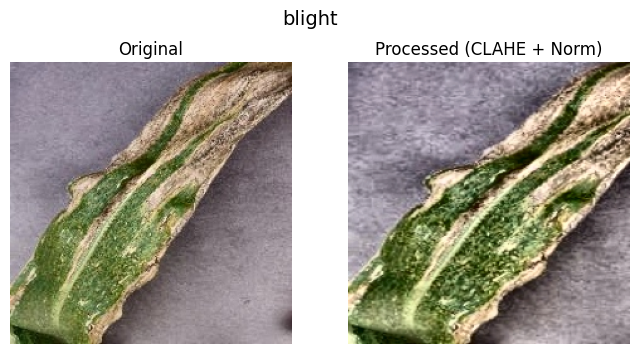

In [ ]:
class_name = 'blight'
test_image_path = f'/content/blight_dataset_processed/Blight/Corn_Blight (1002).JPG'
original_img, processed_img = smart_leaf_crop(test_image_path, class_name)
if processed_img is not None:
    show_images(original_img, processed_img, title=class_name)
else:
    print("Leaf not detected in the image.")

In [ ]:
import os
from tqdm import tqdm

# ✅ ইনপুট ও আউটপুট ফোল্ডার
input_root = '/content/extracted_thesis/data'
output_root = '/content/Maize'  # এখানে সেভ হবে

# ✅ সব ক্লাসের উপর লুপ চালাও
for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # ✅ সেভ ফোল্ডার বানাও
    save_folder = os.path.join(output_root, class_name)
    os.makedirs(save_folder, exist_ok=True)

    # ✅ প্রতিটি ছবির উপর কাজ করো
    for img_name in tqdm(os.listdir(class_path), desc=f'Processing {class_name}'):
        img_path = os.path.join(class_path, img_name)
        save_path = os.path.join(save_folder, img_name)

        try:
            original_img, processed_img = smart_leaf_crop(img_path, class_name)
            if processed_img is not None:
                # [0–1] scale → [0–255] uint8 এ রূপান্তর
                img_uint8 = (processed_img * 255).astype('uint8')
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, img_bgr)
        except Exception as e:
            print(f"Failed on {img_path}: {e}")

Processing Gray_Leaf_Spot: 100%|██████████| 574/574 [00:02<00:00, 226.88it/s]


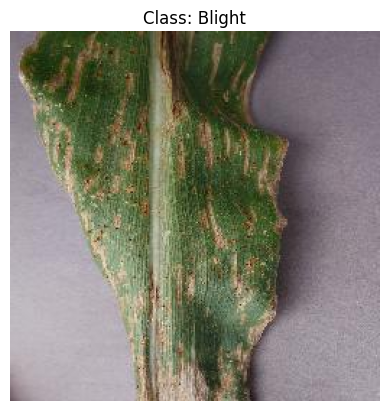

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from skimage.io import imread

# sob class folder list kora
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# ekti random class select
random_class = random.choice(classes)
class_path = os.path.join(dataset_path, random_class)

# sei class folder theke random image select
images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
random_image = random.choice(images)
img_path = os.path.join(class_path, random_image)

# image load & display
img_data = imread(img_path)
plt.imshow(img_data, cmap='gray')
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()


# Data Split : 70 - 30  

In [ ]:
# Create dataframe from image paths
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

image_paths = glob(f'{'/content/Maize'}/*/*.*')
data = pd.DataFrame({
    'filepath': image_paths,
    'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

# Stratified Split
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
#  Copy images to split folders
import shutil
from tqdm import tqdm

def copy_images(df, split_name, base_dir='/content/split'):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        class_dir = os.path.join(base_dir, split_name, row['label'])
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(row['filepath'], class_dir)

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(test_df, 'test')


100%|██████████| 629/629 [00:00<00:00, 2909.08it/s]


### Data augmentation

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import random

# ✅ Base directory of your extracted split dataset
base_train_dir = '/content/split/train'

# ✅ Desired target per class
TARGET_PER_CLASS = 2000

# ✅ Augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomShadow(p=0.3),
    A.ZoomBlur(p=0.2),
   A.ShiftScaleRotate(p=0.3)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# ✅ Apply augmentation only to classes with fewer than target images
for class_name in os.listdir(base_train_dir):
    class_path = os.path.join(base_train_dir, class_name)
    images = os.listdir(class_path)
    current_count = len(images)

    print(f"📁 {class_name}: {current_count} images")

    if current_count >= TARGET_PER_CLASS:
        continue  # Skip if already enough

    to_generate = TARGET_PER_CLASS - current_count
    img_paths = [os.path.join(class_path, img) for img in images]

    for i in tqdm(range(to_generate), desc=f"🔄 Augmenting {class_name}"):
        img_path = random.choice(img_paths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented = augment(image=img)['image']
        save_path = os.path.join(class_path, f'aug_{i}_{os.path.basename(img_path)}')
        cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))


📁 Common_Rust: 914 images


🔄 Augmenting Common_Rust: 100%|██████████| 1086/1086 [00:02<00:00, 395.59it/s]


📁 Healthy: 813 images


🔄 Augmenting Healthy: 100%|██████████| 1187/1187 [00:03<00:00, 385.76it/s]


📁 Blight: 802 images


🔄 Augmenting Blight: 100%|██████████| 1198/1198 [00:04<00:00, 284.16it/s]


📁 Gray_Leaf_Spot: 402 images


🔄 Augmenting Gray_Leaf_Spot: 100%|██████████| 1598/1598 [00:04<00:00, 385.76it/s]


In [ ]:
import os

dataset_path = '/content/split/train'

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


✅ Number of classes: 4
📊 Images per class:
  Common_Rust: 2000 images
  Healthy: 2000 images
  Blight: 2000 images
  Gray_Leaf_Spot: 2000 images


Without parameter tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = target_size
batch_size = 32

# Path to the augmented dataset
augmented_dataset_path = '/content/split/train' # Use the augmented data

# Create data generators for augmented data
train_datagen = ImageDataGenerator(
    rescale=1./105,
    validation_split=0.3 # 30% for validation
)

train_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Found 5600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 50 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.5893 - loss: 1.0546 - val_accuracy: 0.8258 - val_loss: 0.4238
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.8241 - loss: 0.4238 - val_accuracy: 0.7854 - val_loss: 0.4874
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.8540 - loss: 0.3557 - val_accuracy: 0.8654 - val_loss: 0.3799
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9136 - loss: 0.2251 - val_accuracy: 0.8921 - val_loss: 0.2896
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - accuracy: 0.9457 - loss: 0.1431 - val_accuracy: 0.8963 - val_loss: 0.3028
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9666 - loss: 0.1062 - val_accuracy: 0.9004 - val_loss: 0.3547
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9827 - loss: 0.0561 - val_accuracy: 0.8792 - val_loss: 0.4665
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9789 - loss: 0.0517 - val_accurac

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9087 - loss: 1.1711

Validation Loss: 1.1434
Validation Accuracy: 0.9013


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Create test data generator (without augmentation and validation split)
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale the same way as train/validation

test_generator = test_datagen.flow_from_directory(
    '/content/split/test', # Path to the test set
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for correct evaluation
)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Found 629 images belonging to 4 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
                precision    recall  f1-score   support

        Blight       0.92      0.58      0.71       172
   Common_Rust       0.92      0.93      0.92       196
Gray_Leaf_Spot       0.46      0.90      0.61        86
       Healthy       1.00      0.87      0.93       175

      accuracy                           0.81       629
     macro avg       0.82      0.82      0.79       629
  weighted avg       0.88      0.81      0.82       629



#Confusion Matrix

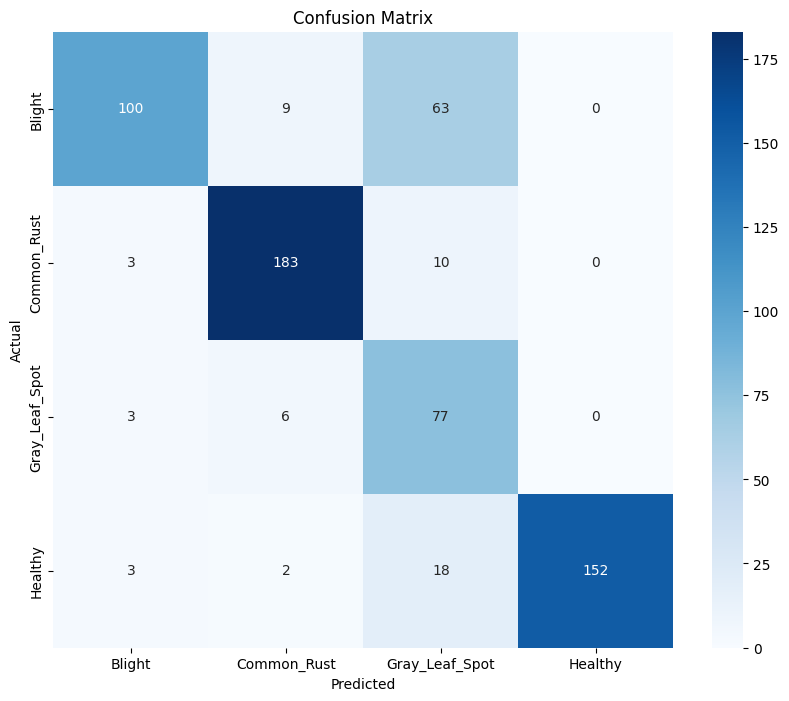

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined from the previous cell
# If not, you would need to regenerate them here

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ROC curve**

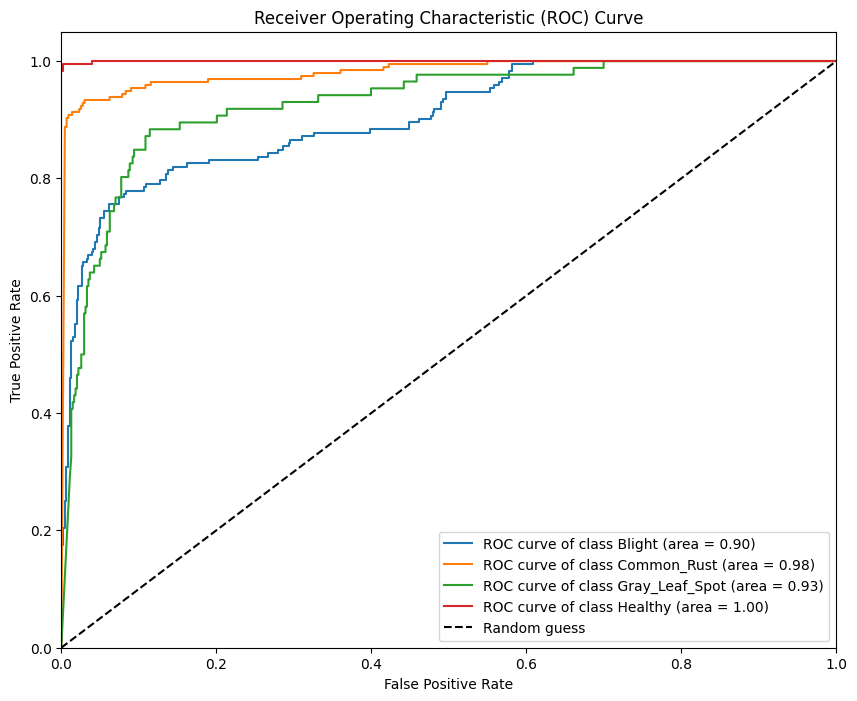

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred and class_names are already defined from previous cells

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Loss and Accuracy

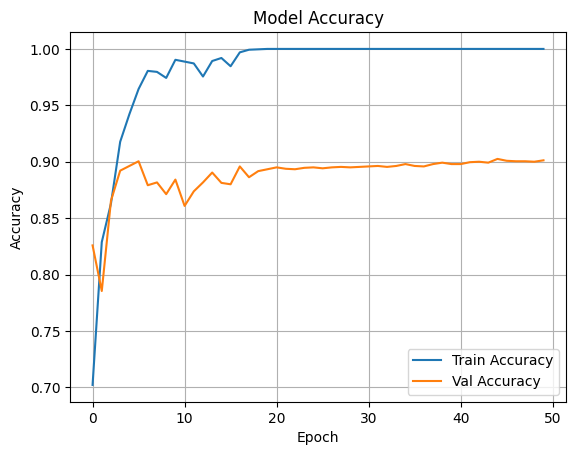

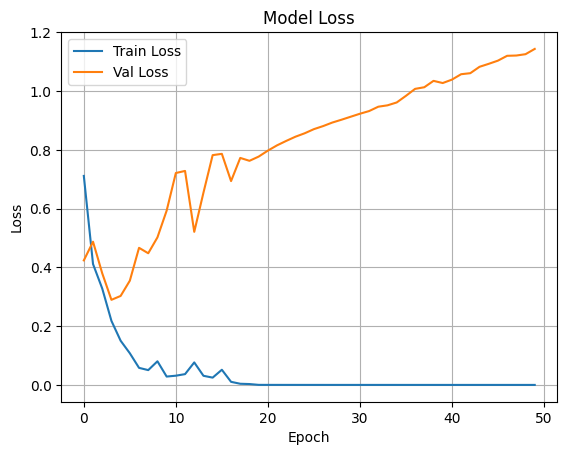

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# **With parameter tuning**

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt

def build_model2(hp):
    model = keras.Sequential()

    # Tune the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice(f'conv_{i+1}_kernel', values=[3, 5]),
            activation=hp.Choice(f'conv_{i+1}_activation', values=['relu', 'tanh', 'sigmoid']),
            input_shape=(img_width, img_height, 3) if i == 0 else None
        ))
        # Tune pool size height and width separately
        pool_size_h = hp.Choice(f'conv_{i+1}_pool_h', values=[2, 3])
        pool_size_w = hp.Choice(f'conv_{i+1}_pool_w', values=[2, 3])
        model.add(layers.MaxPooling2D(pool_size=(pool_size_h, pool_size_w)))

    model.add(layers.Flatten())

    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Tune the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)

    for i in range(num_dense_layers):
         model.add(layers.Dense(
            units=hp.Int(f'dense_{i+1}_units', min_value=32, max_value=128, step=16),
            activation=hp.Choice(f'dense_{i+1}_activation', values=['relu', 'tanh', 'sigmoid'])
        ))

    # Change output layer for multi-class classification
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    # Tune the optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        optimizer = keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    # Change loss function for multi-class classification
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='my_dir2',
    project_name='intro_to_kt2'
)

# Use the existing data generators for the tuner
history = tuner2.search(train_generator, epochs=50, validation_data=validation_generator)

# Get the optimal hyperparameters
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]

print("Available hyperparameters:")
for k, v in best_hps.values.items():
    print(f" - {k}: {v}")

# Safe helper
def hp_val(hps, name, default=None):
    return hps.values.get(name, default)

print(f"\nThe optimal number of convolutional layers is {hp_val(best_hps, 'num_conv_layers')}.")
for i in range(1, hp_val(best_hps, 'num_conv_layers', 0) + 1):
    f = hp_val(best_hps, f'conv_{i}_filter') or hp_val(best_hps, f'conv_{i}_filters')
    k = hp_val(best_hps, f'conv_{i}_kernel')
    a = hp_val(best_hps, f'conv_{i}_activation')

    if f is not None: print(f"Conv{i} filters: {f}")
    if k is not None: print(f"Conv{i} kernel: {k}")
    if a is not None: print(f"Conv{i}_activation: {a}")
    print(f"Conv{i} pooling layer: ({hp_val(best_hps, f'conv_{i}_pool_h')}, {hp_val(best_hps, f'conv_{i}_pool_w')})")


print(f"\nThe optimal number of dense layers is {hp_val(best_hps, 'num_dense_layers')}.")
print(f"Dropout: {hp_val(best_hps, 'dropout') or hp_val(best_hps, 'pre_dense_dropout')}")
for i in range(1, hp_val(best_hps, 'num_dense_layers', 0) + 1):
    u = hp_val(best_hps, f'dense_{i}_units')
    a = hp_val(best_hps, f'dense_{i}_activation')
    if u is not None: print(f"Dense{i} units: {u}")
    if a is not None: print(f"Dense{i} activation: {a}")

print(f"\nOptimizer: {hp_val(best_hps, 'optimizer')}")
print(f"Learning rate: {hp_val(best_hps, 'learning_rate')}")

Trial 1 Complete [00h 10m 31s]
val_accuracy: 0.7879166603088379

Best val_accuracy So Far: 0.7879166603088379
Total elapsed time: 00h 10m 31s
Available hyperparameters:
 - num_conv_layers: 1
 - conv_1_filter: 32
 - conv_1_kernel: 3
 - conv_1_activation: sigmoid
 - conv_1_pool_h: 2
 - conv_1_pool_w: 2
 - dropout: 0.30000000000000004
 - num_dense_layers: 2
 - dense_1_units: 80
 - dense_1_activation: sigmoid
 - optimizer: sgd
 - learning_rate: 0.01
 - dense_2_units: 32
 - dense_2_activation: relu

The optimal number of convolutional layers is 1.
Conv1 filters: 32
Conv1 kernel: 3
Conv1_activation: sigmoid
Conv1 pooling layer: (2, 2)

The optimal number of dense layers is 2.
Dropout: 0.30000000000000004
Dense1 units: 80
Dense1 activation: sigmoid
Dense2 units: 32
Dense2 activation: relu

Optimizer: sgd
Learning rate: 0.01


In [ ]:
# Train the model
# Get the best model
best_model2 = tuner2.get_best_models(num_models=1)[0]
epochs = 50 # You can adjust the number of epochs
history = best_model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7568 - loss: 0.5263 - val_accuracy: 0.7800 - val_loss: 0.5181
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7725 - loss: 0.5037 - val_accuracy: 0.7825 - val_loss: 0.4960
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.7800 - loss: 0.4989 - val_accuracy: 0.7771 - val_loss: 0.5048
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7820 - loss: 0.4878 - val_accuracy: 0.7642 - val_loss: 0.5186
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7915 - loss: 0.4769 - val_accuracy: 0.7908 - val_loss: 0.4980
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.7914 - loss: 0.4772 - val_accuracy: 0.7767 - val_loss: 0.5165
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7908 - loss: 0.4685 - val_accuracy: 0.7812 - val_loss: 0.5106
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8102 - loss: 0.4484 - 

# **Evaluate the model**

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = best_model2.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8258 - loss: 0.5348

Validation Loss: 0.5605
Validation Accuracy: 0.8183


# **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Create test data generator (without augmentation and validation split)
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale the same way as train/validation

test_generator = test_datagen.flow_from_directory(
    '/content/split/test', # Path to the test set
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for correct evaluation
)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = best_model2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Found 629 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step
                precision    recall  f1-score   support

        Blight       0.37      0.78      0.51       172
   Common_Rust       0.98      0.82      0.89       196
Gray_Leaf_Spot       0.46      0.48      0.47        86
       Healthy       0.92      0.07      0.13       175

      accuracy                           0.55       629
     macro avg       0.68      0.54      0.50       629
  weighted avg       0.73      0.55      0.52       629



# **Confusion matrix**

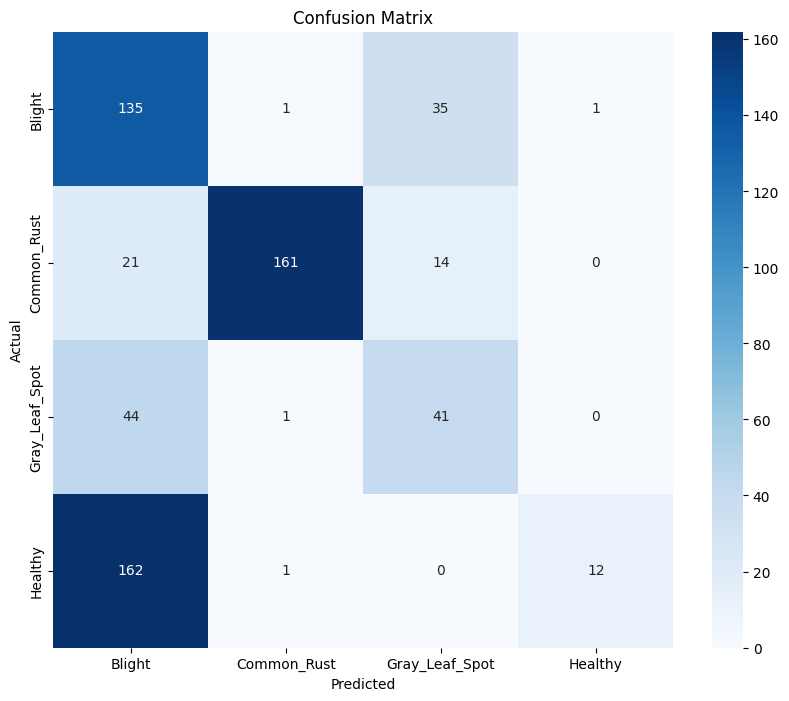

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined from the previous cell
# If not, you would need to regenerate them here

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ROC curve**

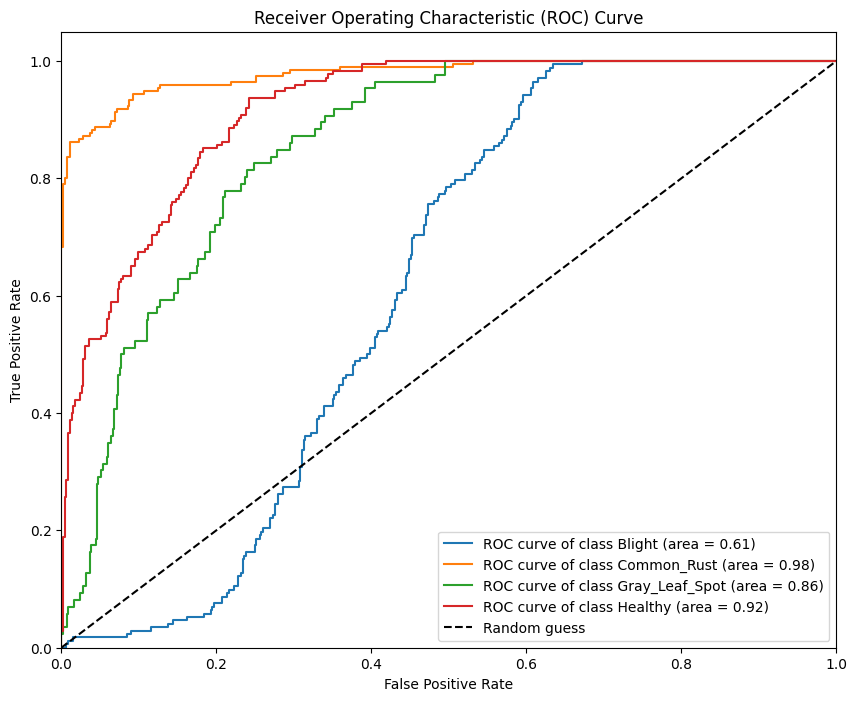

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred and class_names are already defined from previous cells

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Loss and Accuracy**

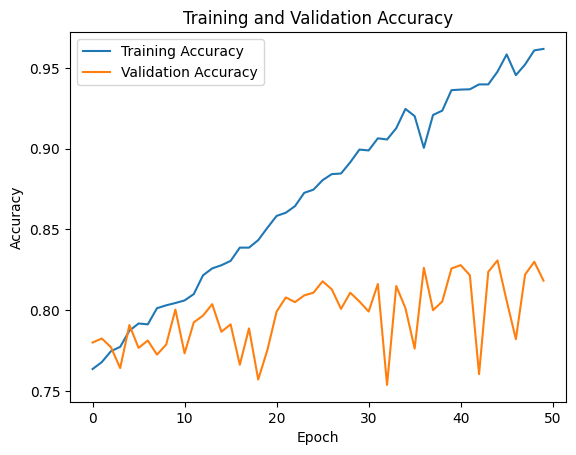

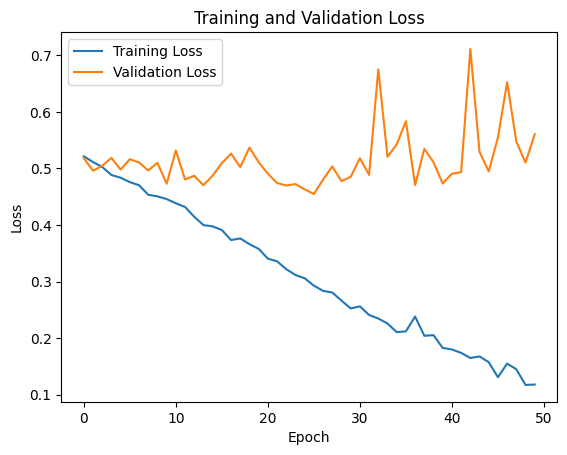

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Split 80-20**

In [ ]:
# Create dataframe from image paths
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import os

image_paths = glob(f'{'/content/Maize'}/*/*.*')
data = pd.DataFrame({
    'filepath': image_paths,
    'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

# Stratified Split
train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

Data augmentation

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import random

# ✅ Base directory of your extracted split dataset
base_train_dir = '/content/split/train'

# ✅ Desired target per class
TARGET_PER_CLASS = 2000

# ✅ Augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomShadow(p=0.3),
    A.ZoomBlur(p=0.2),
   A.ShiftScaleRotate(p=0.3)
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
# ✅ Apply augmentation only to classes with fewer than target images
for class_name in os.listdir(base_train_dir):
    class_path = os.path.join(base_train_dir, class_name)
    images = os.listdir(class_path)
    current_count = len(images)

    print(f"📁 {class_name}: {current_count} images")

    if current_count >= TARGET_PER_CLASS:
        continue  # Skip if already enough

    to_generate = TARGET_PER_CLASS - current_count
    img_paths = [os.path.join(class_path, img) for img in images]

    for i in tqdm(range(to_generate), desc=f"🔄 Augmenting {class_name}"):
        img_path = random.choice(img_paths)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented = augment(image=img)['image']
        save_path = os.path.join(class_path, f'aug_{i}_{os.path.basename(img_path)}')
        cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))


📁 Common_Rust: 2000 images
📁 Healthy: 2000 images
📁 Blight: 2000 images
📁 Gray_Leaf_Spot: 2000 images


In [ ]:
import os

dataset_path = '/content/split/train'

if not os.path.exists(dataset_path):
    print(f"❌ Dataset path not found: {dataset_path}")
else:
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = num_images

    print(f"\n✅ Number of classes: {len(class_counts)}")
    print("📊 Images per class:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


✅ Number of classes: 4
📊 Images per class:
  Common_Rust: 2000 images
  Healthy: 2000 images
  Blight: 2000 images
  Gray_Leaf_Spot: 2000 images


# **Without Parameter tuning**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = target_size
batch_size = 32

# Path to the augmented dataset
augmented_dataset_path = '/content/split/train' # Use the augmented data

# Create data generators for augmented data
train_datagen = ImageDataGenerator(
    rescale=1./105,
    validation_split=0.3 # 30% for validation
)

train_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    augmented_dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Found 5600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 50 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.5453 - loss: 1.8680 - val_accuracy: 0.7567 - val_loss: 0.5009
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.7931 - loss: 0.4623 - val_accuracy: 0.8421 - val_loss: 0.3597
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.8737 - loss: 0.3171 - val_accuracy: 0.8537 - val_loss: 0.3828
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8958 - loss: 0.2660 - val_accuracy: 0.8821 - val_loss: 0.3336
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9263 - loss: 0.1855 - val_accuracy: 0.8817 - val_loss: 0.3328
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.9558 - loss: 0.1213 - val_accuracy: 0.8471 - val_loss: 0.4448
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9792 - loss: 0.0710 - val_accuracy: 0.8900 - val_loss: 0.4315
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9745 - loss: 0.0735 - val_accurac

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8960 - loss: 1.1652

Validation Loss: 1.1214
Validation Accuracy: 0.8925


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Create test data generator (without augmentation and validation split)
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale the same way as train/validation

test_generator = test_datagen.flow_from_directory(
    '/content/split/test', # Path to the test set
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for correct evaluation
)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Found 629 images belonging to 4 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
                precision    recall  f1-score   support

        Blight       0.83      0.72      0.77       172
   Common_Rust       0.94      0.93      0.93       196
Gray_Leaf_Spot       0.53      0.78      0.63        86
       Healthy       0.99      0.90      0.95       175

      accuracy                           0.84       629
     macro avg       0.82      0.83      0.82       629
  weighted avg       0.87      0.84      0.85       629



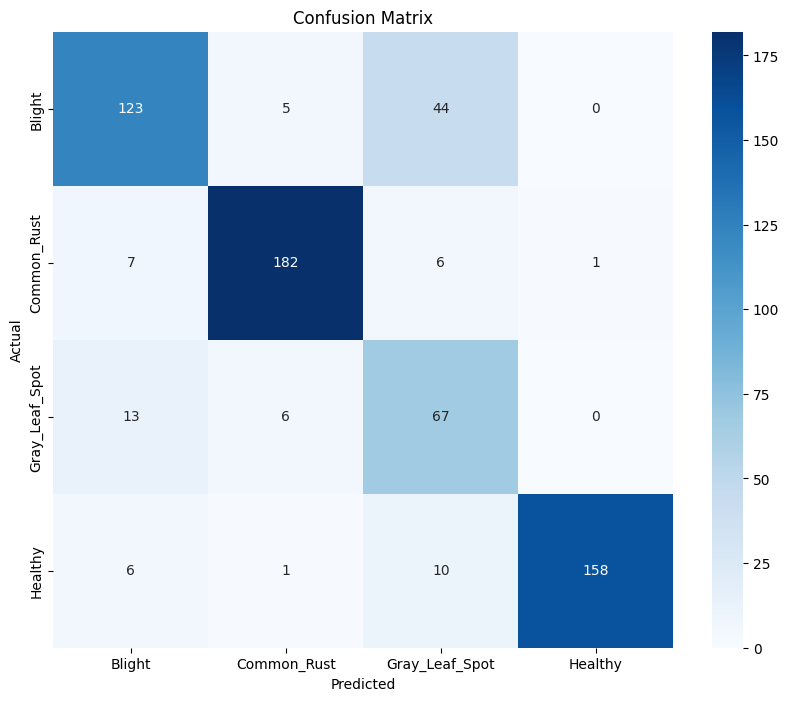

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined from the previous cell
# If not, you would need to regenerate them here

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

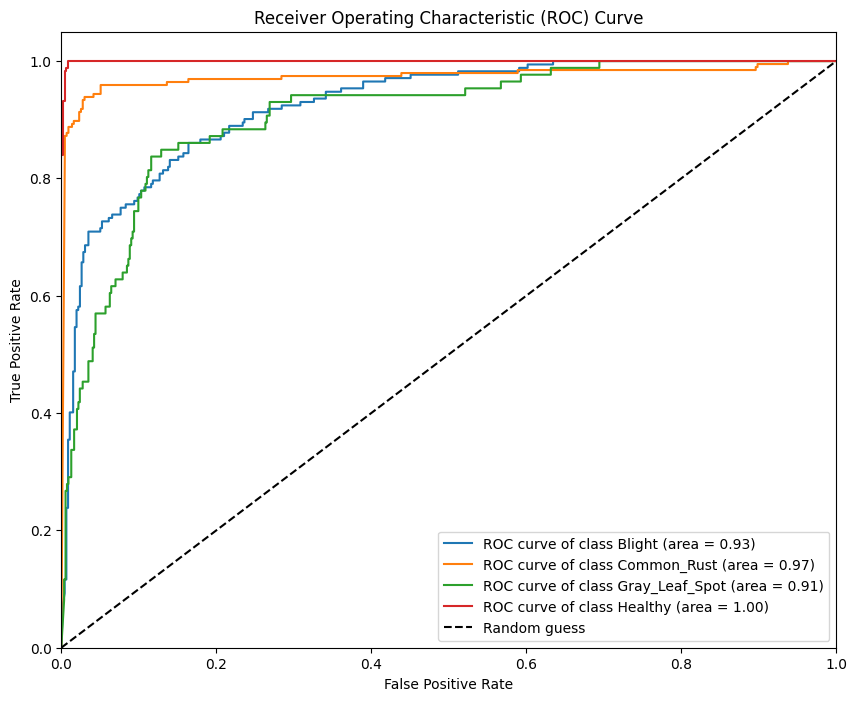

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred and class_names are already defined from previous cells

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

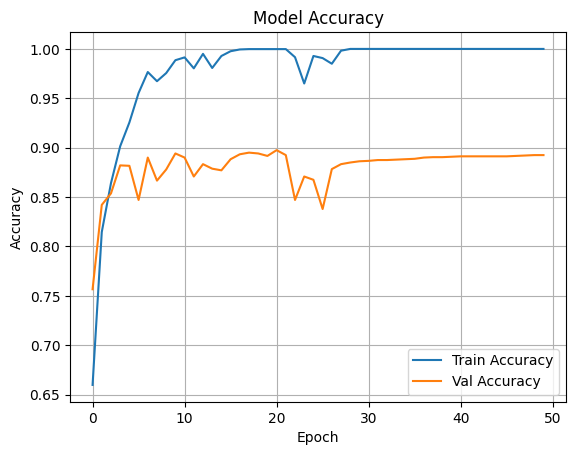

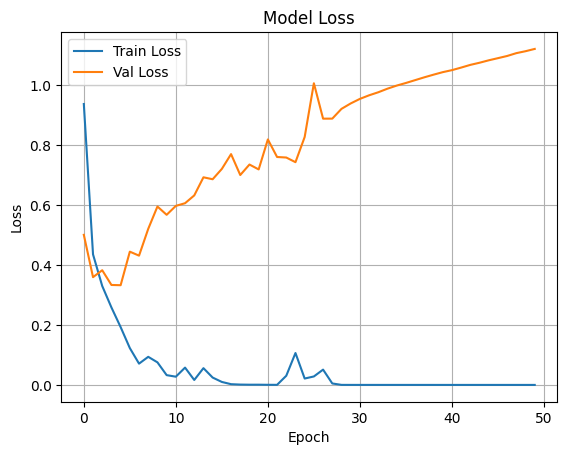

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# **With parameter tuning**

In [ ]:
!pip install keras_tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt

def build_model2(hp):
    model = keras.Sequential()

    # Tune the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice(f'conv_{i+1}_kernel', values=[3, 5]),
            activation=hp.Choice(f'conv_{i+1}_activation', values=['relu', 'tanh', 'sigmoid']),
            input_shape=(img_width, img_height, 3) if i == 0 else None
        ))
        # Tune pool size height and width separately
        pool_size_h = hp.Choice(f'conv_{i+1}_pool_h', values=[2, 3])
        pool_size_w = hp.Choice(f'conv_{i+1}_pool_w', values=[2, 3])
        model.add(layers.MaxPooling2D(pool_size=(pool_size_h, pool_size_w)))

    model.add(layers.Flatten())

    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Tune the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3, step=1)

    for i in range(num_dense_layers):
         model.add(layers.Dense(
            units=hp.Int(f'dense_{i+1}_units', min_value=32, max_value=128, step=16),
            activation=hp.Choice(f'dense_{i+1}_activation', values=['relu', 'tanh', 'sigmoid'])
        ))

    # Change output layer for multi-class classification
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    # Tune the optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        optimizer = keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    # Change loss function for multi-class classification
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='my_dir2',
    project_name='intro_to_kt2'
)

# Use the existing data generators for the tuner
history = tuner2.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the optimal hyperparameters
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]

print("Available hyperparameters:")
for k, v in best_hps.values.items():
    print(f" - {k}: {v}")

# Safe helper
def hp_val(hps, name, default=None):
    return hps.values.get(name, default)

print(f"\nThe optimal number of convolutional layers is {hp_val(best_hps, 'num_conv_layers')}.")
for i in range(1, hp_val(best_hps, 'num_conv_layers', 0) + 1):
    f = hp_val(best_hps, f'conv_{i}_filter') or hp_val(best_hps, f'conv_{i}_filters')
    k = hp_val(best_hps, f'conv_{i}_kernel')
    a = hp_val(best_hps, f'conv_{i}_activation')

    if f is not None: print(f"Conv{i} filters: {f}")
    if k is not None: print(f"Conv{i} kernel: {k}")
    if a is not None: print(f"Conv{i}_activation: {a}")
    print(f"Conv{i} pooling layer: ({hp_val(best_hps, f'conv_{i}_pool_h')}, {hp_val(best_hps, f'conv_{i}_pool_w')})")


print(f"\nThe optimal number of dense layers is {hp_val(best_hps, 'num_dense_layers')}.")
print(f"Dropout: {hp_val(best_hps, 'dropout') or hp_val(best_hps, 'pre_dense_dropout')}")
for i in range(1, hp_val(best_hps, 'num_dense_layers', 0) + 1):
    u = hp_val(best_hps, f'dense_{i}_units')
    a = hp_val(best_hps, f'dense_{i}_activation')
    if u is not None: print(f"Dense{i} units: {u}")
    if a is not None: print(f"Dense{i} activation: {a}")

print(f"\nOptimizer: {hp_val(best_hps, 'optimizer')}")
print(f"Learning rate: {hp_val(best_hps, 'learning_rate')}")

Reloading Tuner from my_dir2/intro_to_kt2/tuner0.json
Available hyperparameters:
 - num_conv_layers: 1
 - conv_1_filter: 32
 - conv_1_kernel: 3
 - conv_1_activation: sigmoid
 - conv_1_pool_h: 2
 - conv_1_pool_w: 2
 - dropout: 0.30000000000000004
 - num_dense_layers: 2
 - dense_1_units: 80
 - dense_1_activation: sigmoid
 - optimizer: sgd
 - learning_rate: 0.01
 - dense_2_units: 32
 - dense_2_activation: relu

The optimal number of convolutional layers is 1.
Conv1 filters: 32
Conv1 kernel: 3
Conv1_activation: sigmoid
Conv1 pooling layer: (2, 2)

The optimal number of dense layers is 2.
Dropout: 0.30000000000000004
Dense1 units: 80
Dense1 activation: sigmoid
Dense2 units: 32
Dense2 activation: relu

Optimizer: sgd
Learning rate: 0.01


In [ ]:
# Train the model
# Get the best model
best_model2 = tuner2.get_best_models(num_models=1)[0]
epochs = 50 # You can adjust the number of epochs
history = best_model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.7572 - loss: 0.5345 - val_accuracy: 0.7683 - val_loss: 0.5165
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7817 - loss: 0.5073 - val_accuracy: 0.7829 - val_loss: 0.5087
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.7862 - loss: 0.4959 - val_accuracy: 0.7679 - val_loss: 0.5289
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.7822 - loss: 0.4912 - val_accuracy: 0.7663 - val_loss: 0.5149
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7886 - loss: 0.4728 - val_accuracy: 0.7808 - val_loss: 0.5044
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7905 - loss: 0.4729 - val_accuracy: 0.7629 - val_loss: 0.5319
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7954 - loss: 0.4651 - val_accuracy: 0.7471 - val_loss: 0.5554
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7959 - loss: 0.4637 - 

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = best_model2.evaluate(validation_generator)
print(f'\nValidation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7517 - loss: 0.7896

Validation Loss: 0.7813
Validation Accuracy: 0.7592


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Create test data generator (without augmentation and validation split)
test_datagen = ImageDataGenerator(rescale=1./255) # Rescale the same way as train/validation

test_generator = test_datagen.flow_from_directory(
    '/content/split/test', # Path to the test set
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for correct evaluation
)

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = best_model2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Found 629 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
                precision    recall  f1-score   support

        Blight       0.37      0.95      0.54       172
   Common_Rust       0.96      0.87      0.91       196
Gray_Leaf_Spot       0.67      0.05      0.09        86
       Healthy       0.88      0.04      0.08       175

      accuracy                           0.55       629
     macro avg       0.72      0.48      0.40       629
  weighted avg       0.74      0.55      0.46       629



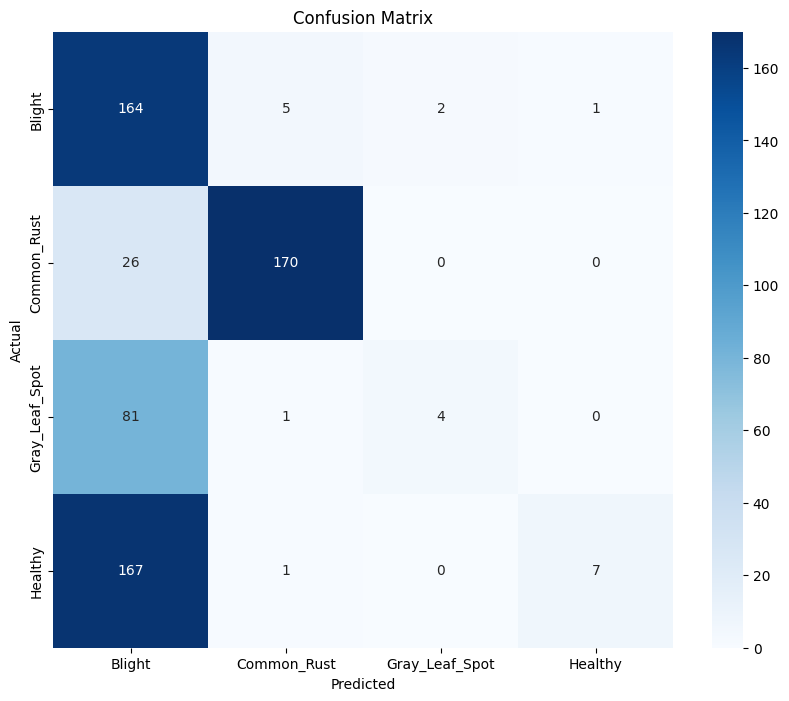

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred_classes are already defined from the previous cell
# If not, you would need to regenerate them here

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

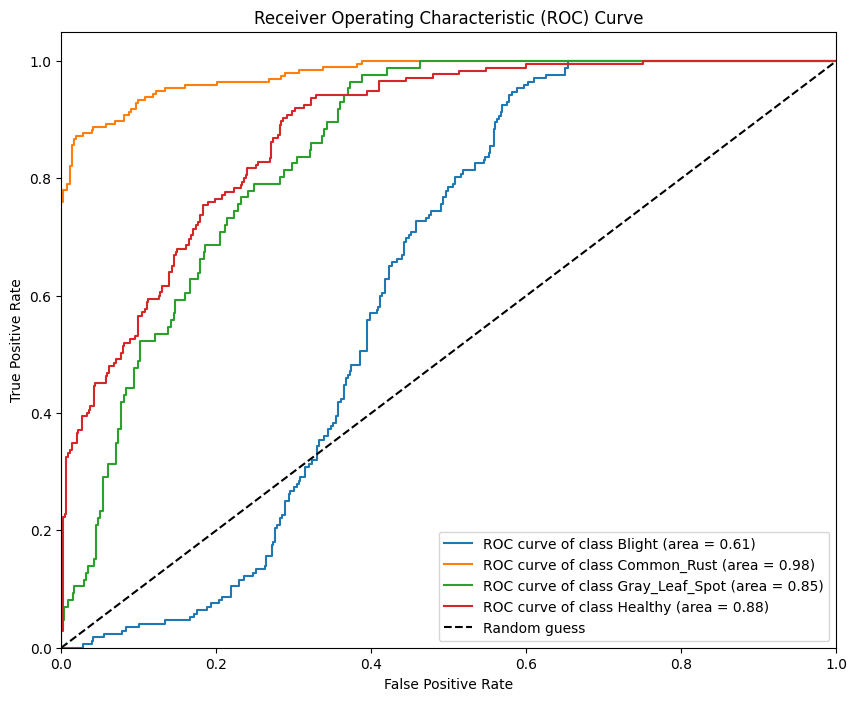

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true, y_pred and class_names are already defined from previous cells

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# **Loss and Accuracy**

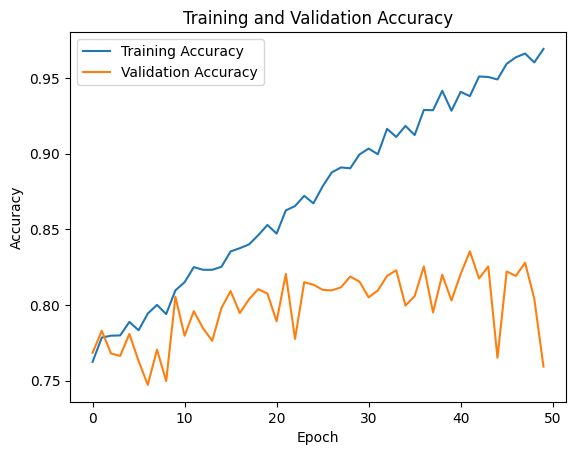

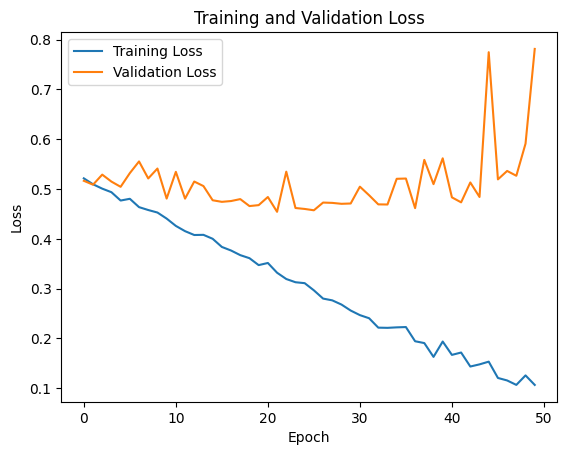

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_model2.save('/content/drive/MyDrive/Maize_CNN_with_Data_augmentation_best_model.h5')

In [ ]:
test_data = []
image='/content/split/train/Blight/Corn_Blight (1).jpeg'
img = cv2.imread(str(image))

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Unable to load image from {image}")
else:
    img = cv2.resize(img, (img_width, img_height))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    test_data.append(img)

    # Convert the list into numpy arrays
    test_data1 = np.array(test_data)
    print("Image loaded and processed successfully.") # Add a success message

Image loaded and processed successfully.


In [ ]:
import cv2
import numpy as np
import os

# Define image dimensions (assuming these are already defined earlier in the notebook)
# img_width, img_height = target_size # Uncomment if not globally available

# Path to the image you want to predict
image_path = '/content/split/train/Blight/Corn_Blight (1000).JPG' # Replace with image path

# Load the image
img = cv2.imread(str(image_path))

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Unable to load image from {image_path}")
else:
    # Preprocess the image
    img = cv2.resize(img, (img_width, img_height))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img / 255.0  # Normalize to [0, 1]

    # Add batch dimension for prediction
    img = np.expand_dims(img, axis=0)

    # Make a prediction
    predictions = best_model2.predict(img)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the actual class name using the index (assuming class_names is defined)
    # If class_names is not defined, you might need to define it here
    # class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'] # Example

    if 'class_names' in locals() or 'class_names' in globals():
        predicted_class_name = class_names[predicted_class_index]
        print(f"Predicted class name: {predicted_class_name}")
    else:
        print(f"Predicted class index: {predicted_class_index}")
        print("Class names are not defined. Cannot print class name.")


    # Optional: Print confidence scores
    print("Confidence scores:")
    if 'class_names' in locals() or 'class_names' in globals():
        for i, score in enumerate(predictions[0]):
            print(f"  {class_names[i]}: {score:.4f}")
    else:
         for i, score in enumerate(predictions[0]):
            print(f"  Class {i}: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class name: Blight
Confidence scores:
  Blight: 0.9658
  Common_Rust: 0.0067
  Gray_Leaf_Spot: 0.0275
  Healthy: 0.0000


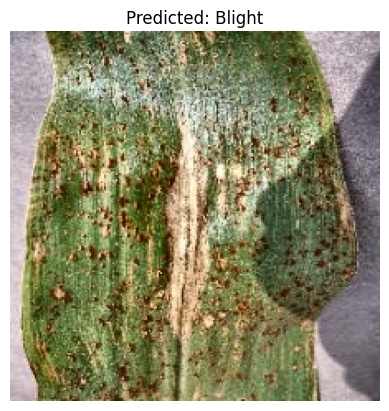

In [ ]:
# Remove the batch dimension before plotting
img_to_show = np.squeeze(img, axis=0)

# Assuming 'predicted_class_name' is defined in the previous cell
label = predicted_class_name

plt.imshow(img_to_show)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()